# Exploitation Zone Images

This notebook builds an image embedding pipeline: it loads S3/MinIO credentials, connects to MinIO and a ChromaDB HTTP server, instantiates a CLIP-based SentenceTransformer, iterates over images in the trusted zone to download each image, converts them to RGB, computes 512‑dim embeddings that are added to a Chroma collection (using the MinIO key as the id), and copies the indexed images into an exploitation bucket. 

**TODO: Recordar que hem de fer les conversions en les altres zones!!!**

In [ ]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()
access_key_id = os.getenv("ACCESS_KEY_ID")
secret_access_key = os.getenv("SECRET_ACCESS_KEY")
minio_url = "http://" + os.getenv("S3_API_ENDPOINT")


minio_client = boto3.client(
    "s3",
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    endpoint_url=minio_url
)

new_bucket = "exploitation-zone"
try:
    minio_client.create_bucket(Bucket=new_bucket)
except (minio_client.exceptions.BucketAlreadyExists, minio_client.exceptions.BucketAlreadyOwnedByYou):
    print(f"Bucket '{new_bucket}' already exists")

Bucket 'exploitation-zone' already exists


In [25]:
import chromadb
from sentence_transformers import SentenceTransformer
from PIL import Image
import io

client = chromadb.HttpClient(host="localhost", port=8000)
paginator = minio_client.get_paginator('list_objects_v2')
exploitation_zone = "exploitation-zone"
trusted_zone = "trusted-zone"

model = SentenceTransformer('clip-ViT-B-32')
collection_name = "exploitation_zone-images"

try:
    client.delete_collection(name=collection_name)
except Exception:
    pass

try:
    collection = client.get_or_create_collection(name=collection_name)
except Exception as e:
    print(f"Error accessing or creating collection: {e}")
    exit(1)

for page in paginator.paginate(Bucket=trusted_zone, Prefix="images/"):
    for obj in page.get("Contents", []):
        key = obj.get("Key", "")
        response = minio_client.get_object(Bucket=trusted_zone, Key=key)
        image_data = response['Body'].read()
        image = Image.open(io.BytesIO(image_data)).convert('RGB')

        embedding = model.encode([image])[0]
        collection.add(
            ids=[key],
            embeddings=[embedding],
        )

        minio_client.copy_object(
            Bucket=exploitation_zone,
            CopySource={'Bucket': trusted_zone, 'Key': key},
            Key=key
        )
result = collection.get()
print("returned keys:", list(result.keys()))

returned keys: ['ids', 'embeddings', 'metadatas', 'documents', 'data', 'uris', 'included']


# Search query
Once the image embeddings are indexed, a search is performed by embedding the query image and finding the nearest neighbours in the vector collection.
It first computes the query embedding with the same model and preprocessing used for the indexed images. Then it submits the query to chromaDB and requests n_results. The returned IDs are the MinIO keys in which the images are closest to the one provided. Finally, it retrieves the image and shows it.

Fetching query image: /home/oriol/Documentos/MDS/ADSDB/notebooks/exploitation_zone/../../query_image.jpeg


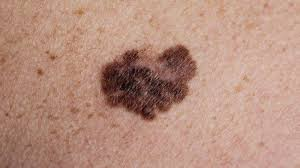

Generating query embedding...
Query embedding generated.
Querying ChromaDB for 5 similar images...

Match 1:
  ID (Minio Key): images/ISIC_0032871.png
  Similarity Distance: 36.8632


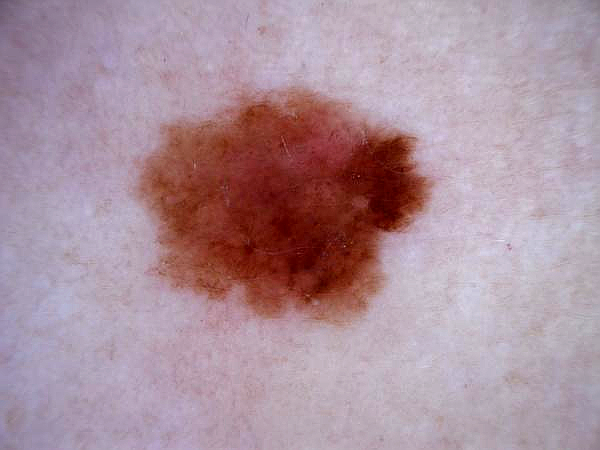

In [ ]:
from IPython.display import display

QUERY_IMAGE_KEY = os.path.join(os.getcwd(), "../../query_image.jpeg")
# read image from local file system
with open(QUERY_IMAGE_KEY, "rb") as f:
    query_image_data = f.read()
try:
    print(f"Fetching query image: {QUERY_IMAGE_KEY}")
    pil_image = Image.open(io.BytesIO(query_image_data))
    pil_image_rgb = pil_image.convert("RGB")
    display(pil_image_rgb)

    print("Generating query embedding...")
    query_embedding = model.encode([pil_image_rgb])[0].tolist()
    print("Query embedding generated.")
    collection = client.get_collection(name=collection_name)
    
    print("Querying ChromaDB for 5 similar images...")
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=1
    )

    if not results['ids'][0]:
        print("No similar images found.")
    else:
        for i in range(len(results['ids'][0])):
            image_id = results['ids'][0][i]
            distance = results['distances'][0][i]
            
            print(f"\nMatch {i+1}:")
            print(f"  ID (Minio Key): {image_id}")
            print(f"  Similarity Distance: {distance:.4f}")
            
            response = minio_client.get_object(Bucket=exploitation_zone, Key=image_id)
            matched_image_data = response['Body'].read()
            matched_image = Image.open(io.BytesIO(matched_image_data)).convert('RGB')
            display(matched_image)

except Exception as e:
    print(f"An error occurred: {e}")